In [11]:
# Import required packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [12]:
# Load data set.
df = pd.read_csv('medication_demand_data.csv')

In [13]:
# Inital view of data.
print(df.head())
print('-' * 75)
# Check data types and non-null counts. Nulls exist! 7300 observations in total.
print(df.info())
print('-' * 75)
# Descriptive statistics for numerical variables.
print(df.describe())
print('-' * 75)
# Count number of nulls in each variable.
print(df.isnull().sum())
print('-' * 75)
# Checking if any other commonly interpreted null values.
print((df == '').sum())
print('-' * 75)
print((df == ' ').sum())
print('-' * 75)
print((df == 'NA').sum())
# Only nulls in this dataset.


         Date      Medication   Sales     Region  Temperature  Humidity  \
0  2023-01-01     Cold Relief  2084.0    Toronto    -3.500000      59.3   
1  2023-01-01     Cold Relief  1372.0  Vancouver     6.600000      57.7   
2  2023-01-01     Cold Relief  1611.0   Montreal   -26.165964      52.9   
3  2023-01-01     Cold Relief  1671.0    Calgary   -13.900000      57.0   
4  2023-01-01  Allergy Relief   351.0    Toronto    -4.400000      50.2   

   Flu_Cases  Pollen_Count  Google_Trends  Marketing_Spend         Holiday  
0      312.0           6.0           95.8          3230.23  New Year's Day  
1      290.0           9.0           75.3          2696.15  New Year's Day  
2      298.0           7.0           74.6          3033.28  New Year's Day  
3      309.0           6.0           77.1          3246.76  New Year's Day  
4      302.0           5.0           48.8           909.67  New Year's Day  
---------------------------------------------------------------------------
<class 'pan

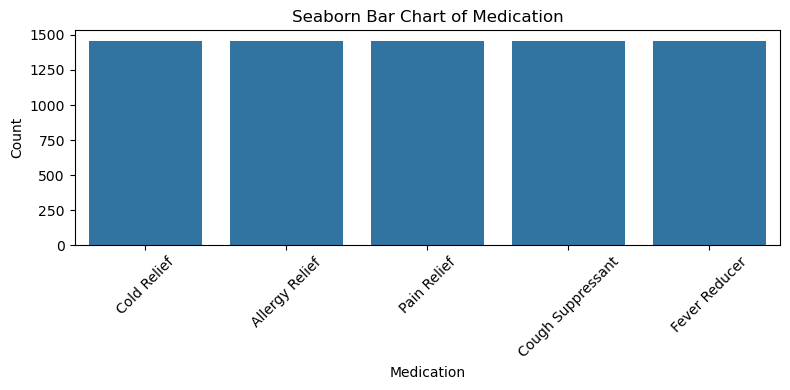

----------------------------------------------------------------------------------------------------


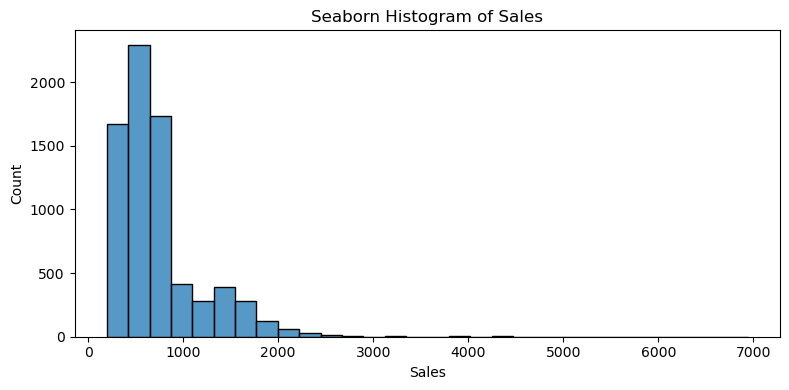

----------------------------------------------------------------------------------------------------


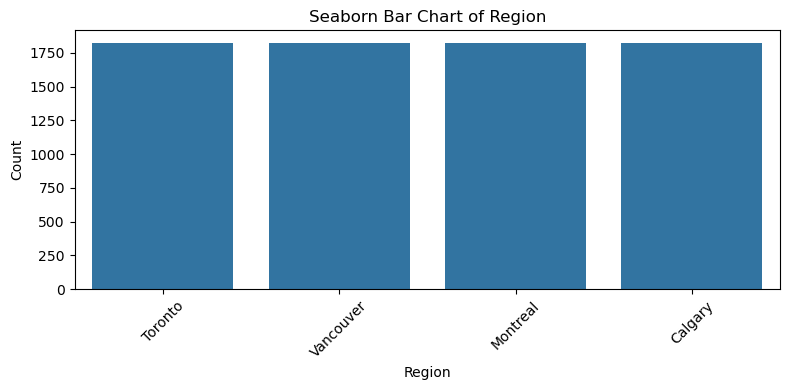

----------------------------------------------------------------------------------------------------


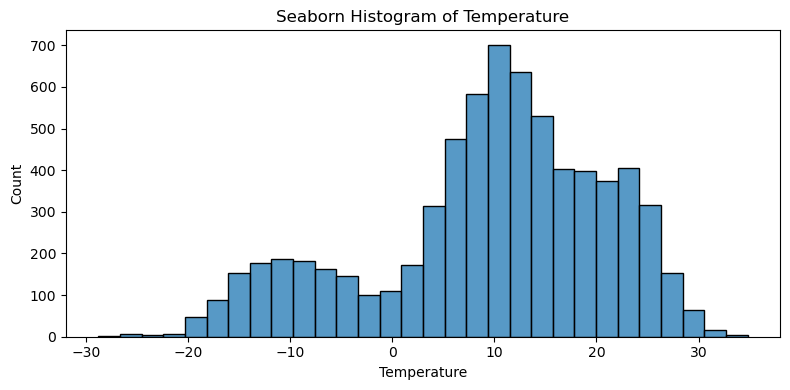

----------------------------------------------------------------------------------------------------


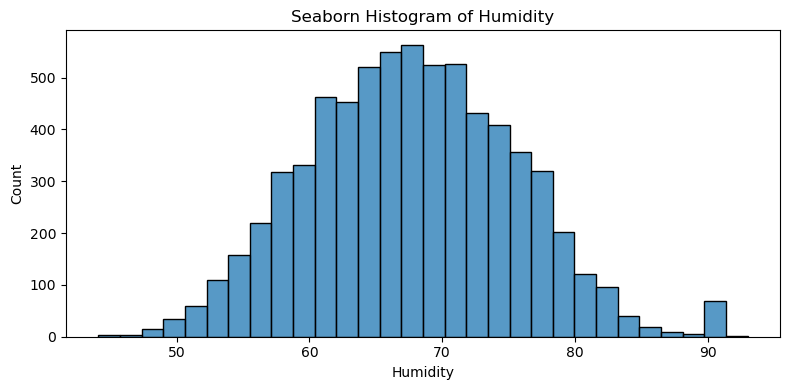

----------------------------------------------------------------------------------------------------


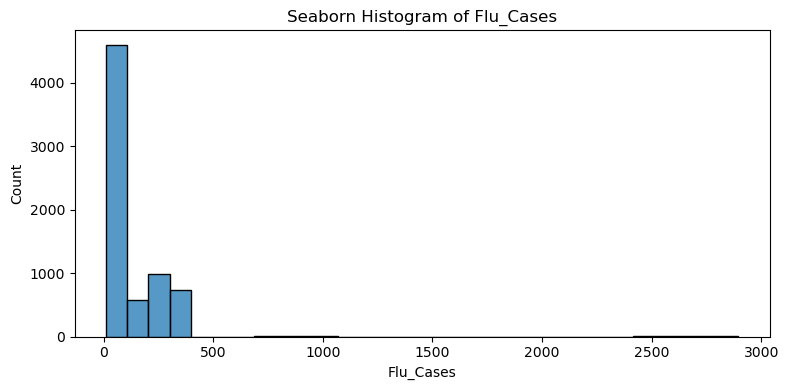

----------------------------------------------------------------------------------------------------


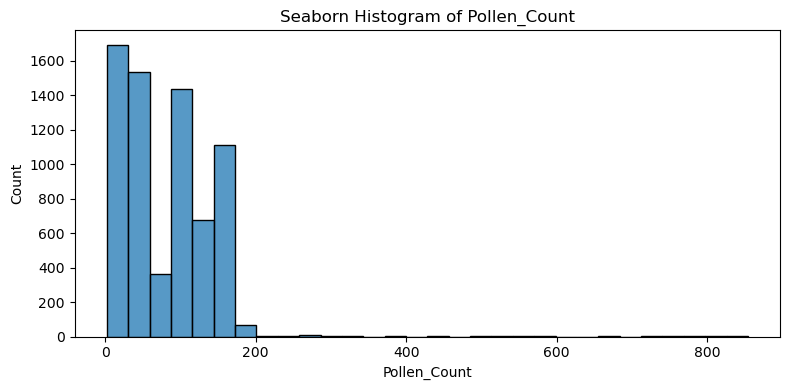

----------------------------------------------------------------------------------------------------


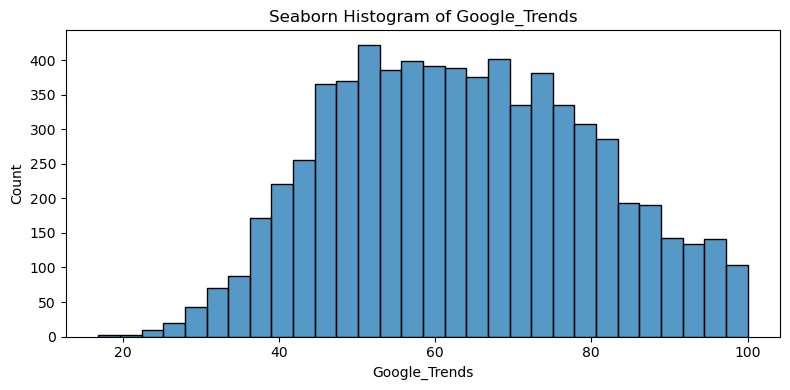

----------------------------------------------------------------------------------------------------


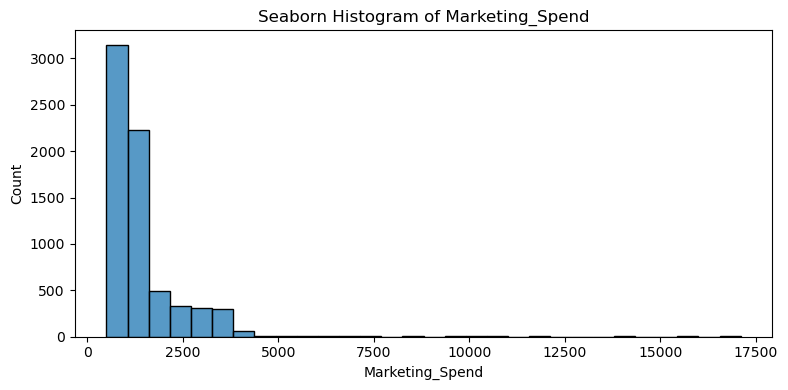

----------------------------------------------------------------------------------------------------


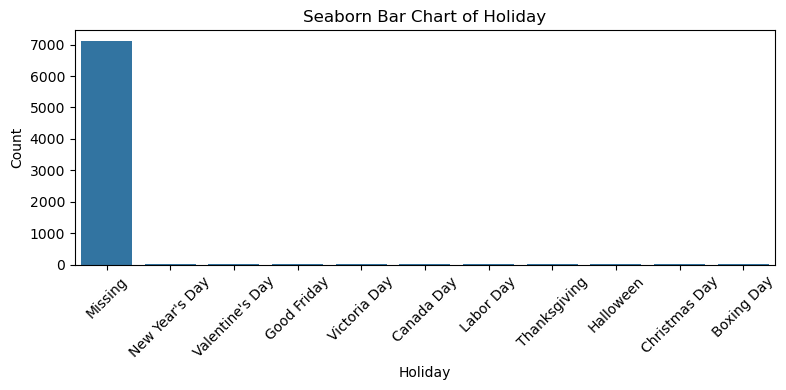

----------------------------------------------------------------------------------------------------


In [14]:
# Define a function to create EDA plots for each variable. 
def EDA(df):
    for col in df.columns:
        # Skip the date column, not informative.
        if col == 'Date':
            continue
        # Replace null values with 'Missing' if they are categorical.
        col_data = df[col].fillna('Missing') if df[col].dtype == 'object' or df[col].dtype.name == 'category' else df[col]
        # Set plot size.
        plt.figure(figsize = (8, 4))

        # If numeric, create a histogram.
        if df[col].dtype in ['int32', 'float64']:
            # Create the seaborn histogram.
            sns.histplot(col_data, bins = 30)
            plt.title(f"Seaborn Histogram of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()
            # Create the plotly histogram.
            fig = px.histogram(df, x = col, title = f"Plotly Histogram of {col}")
            fig.update_layout(title_x = 0.5)  # 0 = left, 0.5 = center, 1 = right
            fig.show()

        # If not numeric, then create a barplot.
        else:
            # Create the seaborn barplot.
            counts = col_data.value_counts()
            sns.barplot(x=counts.index, y = counts.values)
            plt.title(f"Seaborn Bar Chart of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation = 45)
            plt.tight_layout()
            plt.show()
            # Create the plotly barplot.
            fig = px.bar(
                x = counts.index,
                y = counts.values,
                labels = {'x': col, 'y': 'Count'},
                title = f"Plotly Bar Chart of {col}"
            )
            fig.update_layout(title_x = 0.5)
            fig.show()
        print('-' * 100)
# Call function.
EDA(df)

In [15]:
# Preprocessing steps. Create a fresh copy of the data.
df_preprocessed = df.copy()
# First convert 'Date' column to datetime type for month_name() function.
df_preprocessed['Date'] = pd.to_datetime(df_preprocessed['Date'])
# Extract month name into a new 'Month' column. Keep 'Date' column in case of future analyses.
df_preprocessed['Month'] = df_preprocessed['Date'].dt.month_name()
# Binarize 'Holiday' column. First fill null values with an empty string for later recognition.
df_preprocessed['Holiday'] = df_preprocessed['Holiday'].fillna('')
# Define a function to classify the holiday as either a holiday or not.
def binarize_holiday(x):
    if x.strip() != '':
        return 'Holiday'
    else:
        return 'Not a Holiday'
# Apply the function to each value in the 'Holiday' column.
df_preprocessed['Holiday'] = df_preprocessed['Holiday'].apply(binarize_holiday)
# Round down all values in the 'Sales' column as they intended to be whole number integers but some are floats. 
df_preprocessed['Sales'] = np.floor(df_preprocessed['Sales']).astype(int)
# View changes for the first few rows to ensure changes have taken effect. 
print(df_preprocessed.head())
# Check that 'Sales' is now integer type instead of float.
print(df_preprocessed.dtypes)




        Date      Medication  Sales     Region  Temperature  Humidity  \
0 2023-01-01     Cold Relief   2084    Toronto    -3.500000      59.3   
1 2023-01-01     Cold Relief   1372  Vancouver     6.600000      57.7   
2 2023-01-01     Cold Relief   1611   Montreal   -26.165964      52.9   
3 2023-01-01     Cold Relief   1671    Calgary   -13.900000      57.0   
4 2023-01-01  Allergy Relief    351    Toronto    -4.400000      50.2   

   Flu_Cases  Pollen_Count  Google_Trends  Marketing_Spend  Holiday    Month  
0      312.0           6.0           95.8          3230.23  Holiday  January  
1      290.0           9.0           75.3          2696.15  Holiday  January  
2      298.0           7.0           74.6          3033.28  Holiday  January  
3      309.0           6.0           77.1          3246.76  Holiday  January  
4      302.0           5.0           48.8           909.67  Holiday  January  
Date               datetime64[ns]
Medication                 object
Sales              

In [16]:
# Imputation time. Check again number of nulls in each variable.
print(df_preprocessed.isnull().sum())
print('-' * 50)
# Maximum number of nulls is 381, which is less than 30% of total observations. Proceed with imputation.
# Create imputer object.
imputer = IterativeImputer(random_state=0)
# Fit and impute (multiple imputation) columns with missingness.
df_clean = df_preprocessed.copy()
df_clean[['Temperature', 'Humidity', 'Flu_Cases', 'Pollen_Count', 'Google_Trends', 'Marketing_Spend']] = imputer.fit_transform(
    df_clean[['Temperature', 'Humidity', 'Flu_Cases', 'Pollen_Count', 'Google_Trends', 'Marketing_Spend']])
# Check descriptive statistics again, pre- and post-imputation.
print(df_preprocessed.describe())
print('-' * 50)
print(df_clean.describe())
print('-' * 50)
# Calculate and print a table of the difference in descriptive statistics as a result of multiple imputation.
desc_before = df_preprocessed.describe()
desc_after = df_clean.describe()
desc_diff = desc_after - desc_before
# Print only imputed columns.
columns_of_interest = ['Temperature', 'Humidity', 'Flu_Cases', 'Pollen_Count', 'Google_Trends', 'Marketing_Spend']
print(desc_diff[columns_of_interest])

Date                 0
Medication           0
Sales                0
Region               0
Temperature        381
Humidity           374
Flu_Cases          348
Pollen_Count       370
Google_Trends      368
Marketing_Spend    380
Holiday              0
Month                0
dtype: int64
--------------------------------------------------
                                Date        Sales  Temperature     Humidity  \
count                           7300  7300.000000  6919.000000  6926.000000   
mean   2023-07-02 00:00:00.000000256   733.711781     9.500998    67.692249   
min              2023-01-01 00:00:00   197.000000   -28.765964    44.100000   
25%              2023-04-02 00:00:00   438.000000     4.400000    62.100000   
50%              2023-07-02 00:00:00   620.000000    11.000000    67.600000   
75%              2023-10-01 00:00:00   818.000000    17.900000    73.100000   
max              2023-12-31 00:00:00  6941.000000    34.800000    93.000000   
std                         

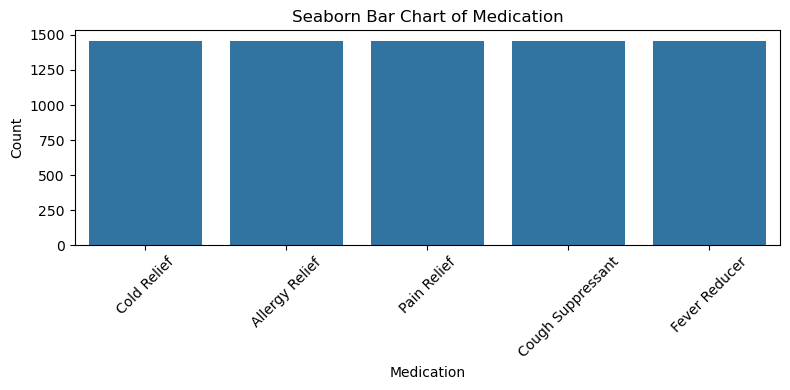

----------------------------------------------------------------------------------------------------


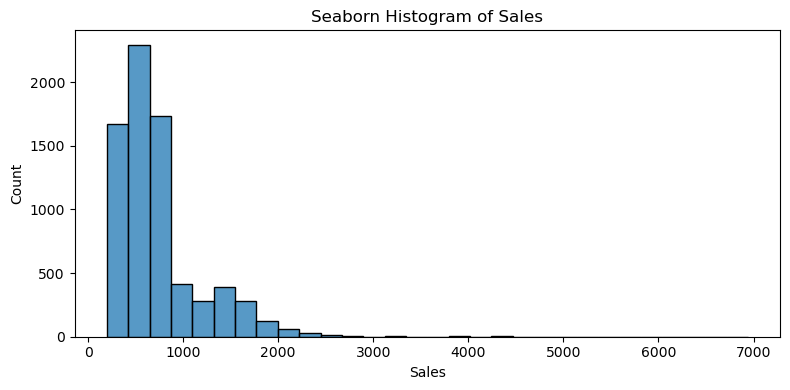

----------------------------------------------------------------------------------------------------


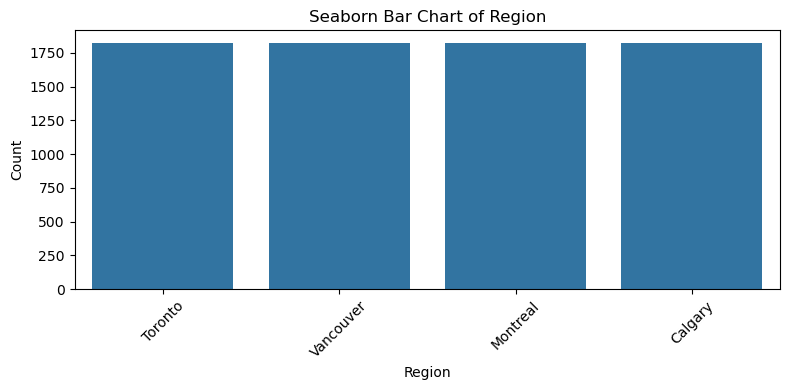

----------------------------------------------------------------------------------------------------


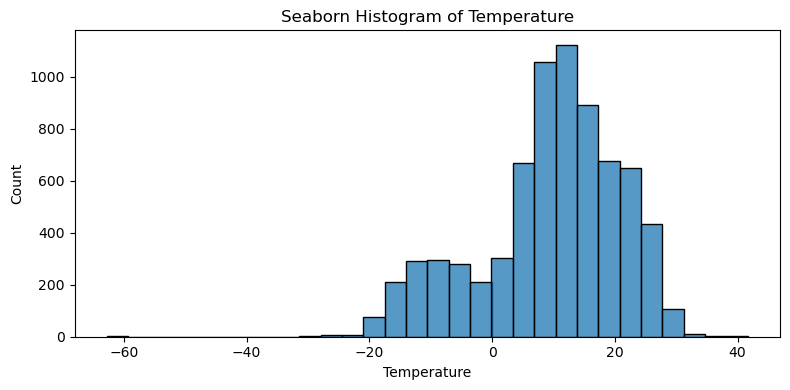

----------------------------------------------------------------------------------------------------


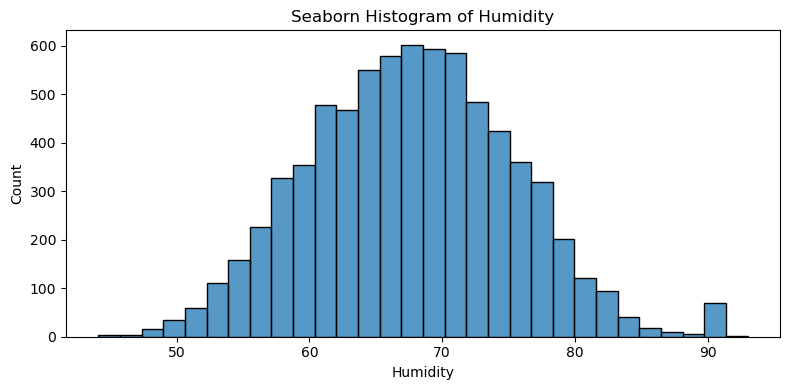

----------------------------------------------------------------------------------------------------


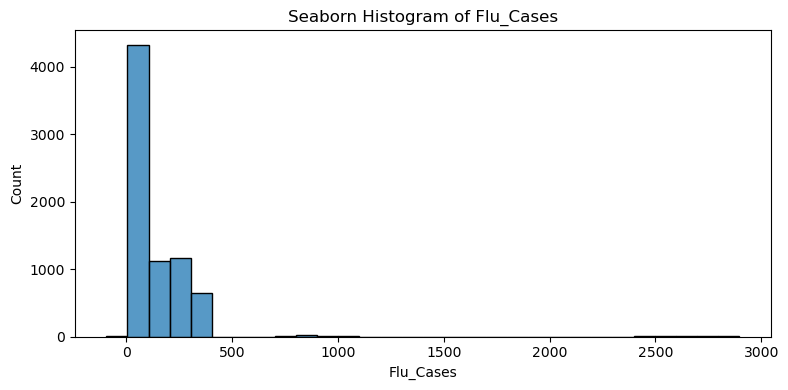

----------------------------------------------------------------------------------------------------


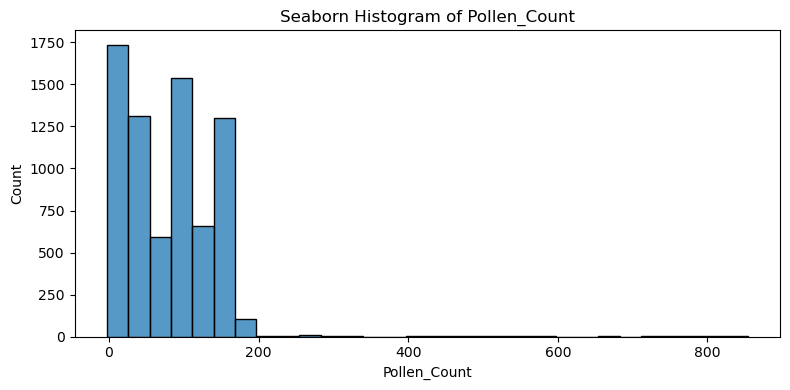

----------------------------------------------------------------------------------------------------


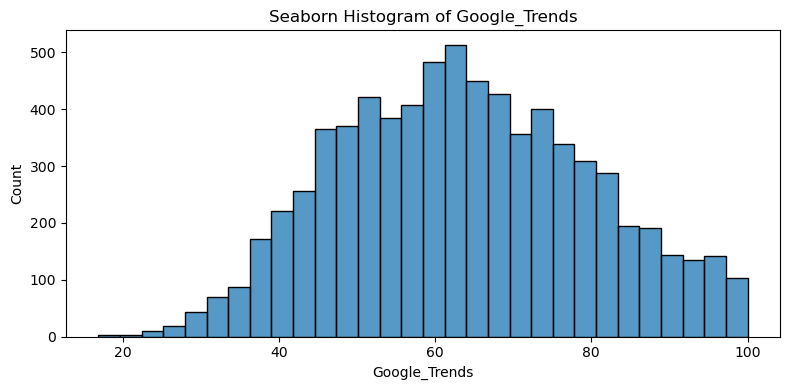

----------------------------------------------------------------------------------------------------


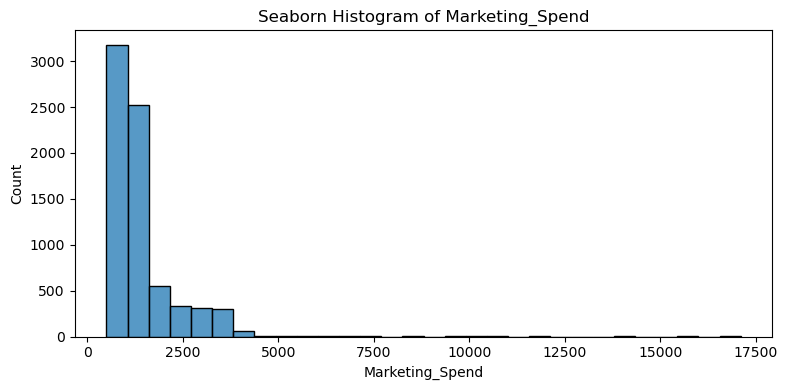

----------------------------------------------------------------------------------------------------


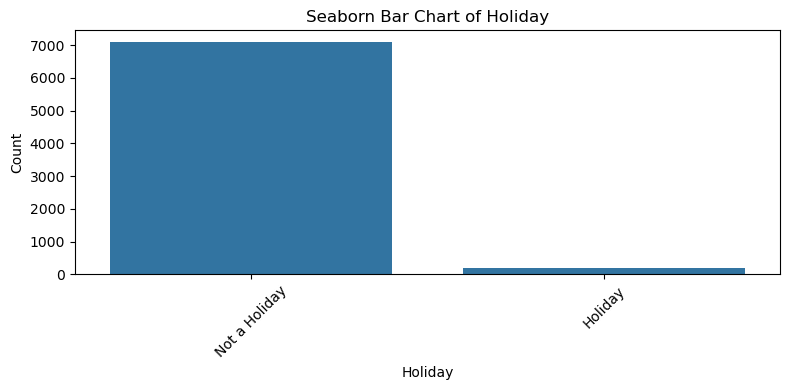

----------------------------------------------------------------------------------------------------


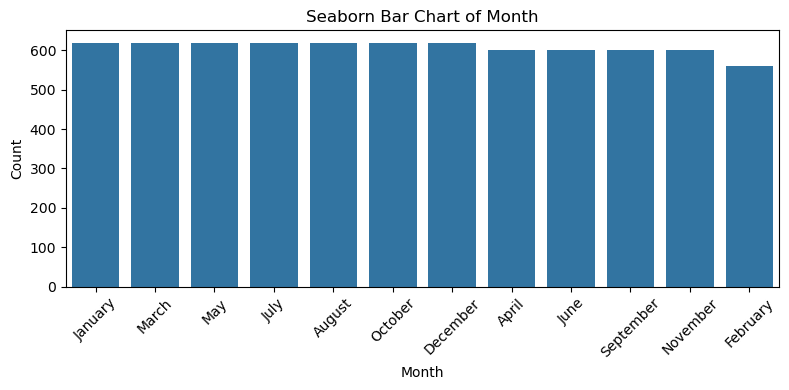

----------------------------------------------------------------------------------------------------


In [17]:
# Let's regenerate the EDA plots now that we have our final dataset. 
EDA(df_clean)

In [18]:
# Extra check for overfitting rule of thumb. Ideal to have (number of samples in smallest class / number of predictors) be greater or equal to 
# 10-15. We have 11 features (12 if using both 'Date' and 'Month', though this is not recommended due to potential multicollinearity).
print(min(
    df_clean['Medication'].value_counts().min(),
    df_clean['Region'].value_counts().min(),
    df_clean['Holiday'].value_counts().min(),
    df_clean['Month'].value_counts().min()
    )
)
# The smallest class has 200 values (i.e. 'Holiday' in the 'Holiday' column).
print(200/12)
print(200/11)
# Passes the rule of thumb!



200
16.666666666666668
18.181818181818183


In [19]:
# Time for some machine learning to predict medication demand. First import necessary packages.
